In [260]:
import pandas as pd
import os
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[10,10])
# plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))import cv2

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [261]:
protoFile = "C:/Users/romanrosh/openpose-1.4.0-win64-gpu-binaries/models/pose/body_25/pose_deploy.prototxtpose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "C:/Users/romanrosh/openpose-1.4.0-win64-gpu-binaries/models/pose/body_25/pose_iter_584000.caffemodel"
nPoints = 25
POSE_PAIRS = [[1, 0], [1, 2], [1, 5], [2, 3], [3, 4], [5, 6], [6, 7], [1, 8], [8, 9], [9, 10], [1, 11], [11, 12],
              [12, 13], [0, 14], [0, 15], [14, 16], [15, 17],
              [10, 11], [8, 12], [12, 13], [13, 14], [1, 0], [0, 15], [0, 16], [16, 18], [2, 17], [5, 18], [14, 19],
              [19, 20], [14, 21], [11, 22], [22, 23], [11, 24]]

## Additional Data Exploration

In [379]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils.np_utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [380]:
df=pd.read_csv('C:/Users/romanrosh/PycharmProjects/bio-mechanic-movmement-detector-ai/destination/Data for fit/combined.csv')

In [381]:
df.head()

,0-XNose,0-YNose,1-XNeck,1-YNeck,2-XRShoulder,2-YRShoulder,3-XRElbow,3-YRElbow,4-XRWrist,4-YRWrist,...,24-XRHeel,24-YRHeel,RightKneeAngle,LeftKneeAngle,LeftHeelAngleAngle,RightHeelAngleAngle,HipAngle,XHead,YHead,label
0,197.800,93.000000,198.000,140.104,198.000,128.52,166.0,135.6,124.8,140.000000,...,240.000000,320.000000,107.168036,167.331718,134.053860,35.325333,141.854213,200.7600,113.600000,bottom
1,190.112,94.800000,201.875,140.400,199.125,129.40,166.0,135.6,124.8,140.000000,...,239.576000,285.600000,85.582556,151.294499,104.876052,42.240797,115.723601,199.2224,110.777143,midway
2,172.800,94.800000,201.875,140.400,199.125,129.40,166.0,135.6,124.8,162.600000,...,226.750000,277.000000,85.180562,145.492851,109.172939,39.038346,115.723601,190.6800,110.777143,midway
3,197.800,88.384504,198.000,140.400,176.800,129.40,166.0,135.6,124.8,124.666667,...,240.000000,320.000000,107.168036,169.894486,143.679704,82.198861,141.062676,200.7600,105.558351,top
4,197.800,93.000000,198.000,125.000,198.000,117.00,166.0,135.6,124.8,162.600000,...,228.958333,284.166667,102.993032,167.331718,134.053860,39.903087,144.683628,200.7600,113.600000,bottom


In [382]:
df['label'] = df['label'].map({'top': 1, 'midway': -1, 'bottom': 0})

In [383]:
df.head()

,0-XNose,0-YNose,1-XNeck,1-YNeck,2-XRShoulder,2-YRShoulder,3-XRElbow,3-YRElbow,4-XRWrist,4-YRWrist,...,24-XRHeel,24-YRHeel,RightKneeAngle,LeftKneeAngle,LeftHeelAngleAngle,RightHeelAngleAngle,HipAngle,XHead,YHead,label
0,197.800,93.000000,198.000,140.104,198.000,128.52,166.0,135.6,124.8,140.000000,...,240.000000,320.000000,107.168036,167.331718,134.053860,35.325333,141.854213,200.7600,113.600000,0
1,190.112,94.800000,201.875,140.400,199.125,129.40,166.0,135.6,124.8,140.000000,...,239.576000,285.600000,85.582556,151.294499,104.876052,42.240797,115.723601,199.2224,110.777143,-1
2,172.800,94.800000,201.875,140.400,199.125,129.40,166.0,135.6,124.8,162.600000,...,226.750000,277.000000,85.180562,145.492851,109.172939,39.038346,115.723601,190.6800,110.777143,-1
3,197.800,88.384504,198.000,140.400,176.800,129.40,166.0,135.6,124.8,124.666667,...,240.000000,320.000000,107.168036,169.894486,143.679704,82.198861,141.062676,200.7600,105.558351,1
4,197.800,93.000000,198.000,125.000,198.000,117.00,166.0,135.6,124.8,162.600000,...,228.958333,284.166667,102.993032,167.331718,134.053860,39.903087,144.683628,200.7600,113.600000,0


In [384]:
df = df[df.label != -1]

In [385]:
df.head()

,0-XNose,0-YNose,1-XNeck,1-YNeck,2-XRShoulder,2-YRShoulder,3-XRElbow,3-YRElbow,4-XRWrist,4-YRWrist,...,24-XRHeel,24-YRHeel,RightKneeAngle,LeftKneeAngle,LeftHeelAngleAngle,RightHeelAngleAngle,HipAngle,XHead,YHead,label
0,197.800000,93.000000,198.000000,140.104000,198.0,128.52,166.0,135.6,124.8,140.000000,...,240.000000,320.000000,107.168036,167.331718,134.053860,35.325333,141.854213,200.760000,113.600000,0
3,197.800000,88.384504,198.000000,140.400000,176.8,129.40,166.0,135.6,124.8,124.666667,...,240.000000,320.000000,107.168036,169.894486,143.679704,82.198861,141.062676,200.760000,105.558351,1
4,197.800000,93.000000,198.000000,125.000000,198.0,117.00,166.0,135.6,124.8,162.600000,...,228.958333,284.166667,102.993032,167.331718,134.053860,39.903087,144.683628,200.760000,113.600000,0
7,197.800000,87.758095,198.000000,140.400000,176.8,129.40,166.0,135.6,124.8,124.055556,...,234.952381,303.619048,102.993032,167.331718,158.257164,56.648705,138.982021,200.760000,105.288118,1
9,170.057143,93.200000,203.747768,108.131696,176.8,129.40,166.0,135.6,124.8,133.000000,...,235.478175,305.325397,92.678334,179.173653,143.679704,59.613684,128.169465,189.607347,112.954636,0


In [386]:
X = df.loc[:,:'YHead']
y = df.loc[:,'label']

In [388]:
from sklearn import preprocessing

x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

In [389]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [390]:
print(X_train.shape)

(532, 57)


In [391]:
model=Sequential()
model.add(Dense(64,activation='relu',input_shape=(57,)))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [392]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 64)                3712      
_________________________________________________________________
dense_109 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_110 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_111 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_112 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_113 (Dense)            (None, 2)                 10        
Total params: 6,502
Trainable params: 6,502
Non-trainable params: 0
_________________________________________________________________


In [393]:
history=model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test))

Train on 532 samples, validate on 134 samples
Epoch 1/100
532/532 [==============================] - 1s 2ms/step - loss: 0.6932 - acc: 0.4925 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/100
532/532 [==============================] - 0s 141us/step - loss: 0.6932 - acc: 0.4925 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/100
532/532 [==============================] - 0s 148us/step - loss: 0.6930 - acc: 0.5432 - val_loss: 0.6925 - val_acc: 0.5448
Epoch 4/100
532/532 [==============================] - 0s 152us/step - loss: 0.6910 - acc: 0.5000 - val_loss: 0.6873 - val_acc: 0.5000
Epoch 5/100
532/532 [==============================] - 0s 141us/step - loss: 0.6817 - acc: 0.4981 - val_loss: 0.6665 - val_acc: 0.5000
Epoch 6/100
532/532 [==============================] - 0s 144us/step - loss: 0.6565 - acc: 0.4981 - val_loss: 0.6346 - val_acc: 0.5000
Epoch 7/100
532/532 [==============================] - 0s 146us/step - loss: 0.6180 - acc: 0.6316 - val_loss: 0.5928 - val_acc: 0.6567
Epoch 8/100

Epoch 61/100
532/532 [==============================] - 0s 144us/step - loss: 0.1671 - acc: 0.9511 - val_loss: 0.2816 - val_acc: 0.8806
Epoch 62/100
532/532 [==============================] - 0s 139us/step - loss: 0.1747 - acc: 0.9549 - val_loss: 0.2733 - val_acc: 0.8806
Epoch 63/100
532/532 [==============================] - 0s 152us/step - loss: 0.1900 - acc: 0.9342 - val_loss: 0.2802 - val_acc: 0.8806
Epoch 64/100
532/532 [==============================] - 0s 156us/step - loss: 0.1679 - acc: 0.9474 - val_loss: 0.2685 - val_acc: 0.8806
Epoch 65/100
532/532 [==============================] - 0s 139us/step - loss: 0.1734 - acc: 0.9417 - val_loss: 0.2896 - val_acc: 0.8806
Epoch 66/100
532/532 [==============================] - 0s 135us/step - loss: 0.1762 - acc: 0.9455 - val_loss: 0.2813 - val_acc: 0.8806
Epoch 67/100
532/532 [==============================] - 0s 144us/step - loss: 0.1655 - acc: 0.9530 - val_loss: 0.2847 - val_acc: 0.8657
Epoch 68/100
532/532 [==========================

In [394]:
print(history.history['acc'])

[0.4924812032315964, 0.49248120255936356, 0.543233082706767, 0.49999999910368953, 0.49812029985556927, 0.49812030164819016, 0.631578947368421, 0.7312030079669523, 0.7725563914255988, 0.8665413529353034, 0.8496240592540655, 0.8834586457202309, 0.8966165404570731, 0.902255638201434, 0.9116541344420355, 0.9154135338345865, 0.9097744360902256, 0.9116541344420355, 0.9172932326345515, 0.926691728875153, 0.9191729318826718, 0.9229323303789124, 0.9248120291788775, 0.9323308266195139, 0.9248120296270328, 0.9398496236119952, 0.9248120291788775, 0.9191729327789823, 0.924812030075188, 0.9379699243638748, 0.9285714285714286, 0.9379699243638748, 0.9304511269232384, 0.9379699239157196, 0.9436090221082357, 0.9304511287158593, 0.9323308266195139, 0.9454887213563561, 0.9379699248120301, 0.9342105258676342, 0.9323308266195139, 0.9417293228601155, 0.9398496236119952, 0.9454887213563561, 0.9417293242045811, 0.9379699243638748, 0.9417293233082706, 0.943609022556391, 0.9360902251157546, 0.9323308266195139, 0

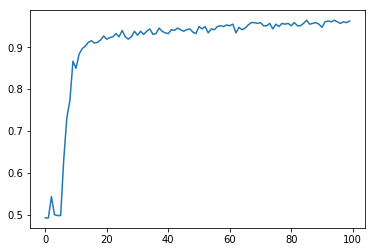

In [395]:
plt.plot(history.history['acc'])

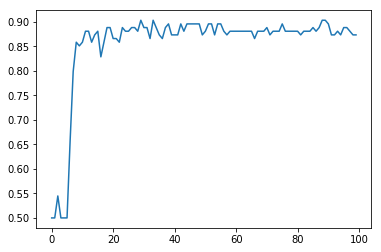

In [396]:
plt.plot(history.history['val_acc'])

In [278]:
# model.save('C:/Users/romanrosh/PycharmProjects/bio-mechanic-movmement-detector-ai/destination/saved_model')

In [279]:
# model.load_weights('C:/Users/romanrosh/PycharmProjects/bio-mechanic-movmement-detector-ai/destination/saved_model')

In [338]:
# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# model.summary()

In [281]:
df.fillna(-1,inplace=True)
df.head()

,0-XNose,0-YNose,1-XNeck,1-YNeck,2-XRShoulder,2-YRShoulder,3-XRElbow,3-YRElbow,4-XRWrist,4-YRWrist,...,24-XRHeel,24-YRHeel,RightKneeAngle,LeftKneeAngle,LeftHeelAngleAngle,RightHeelAngleAngle,HipAngle,XHead,YHead,label
0,197.800000,93.000000,198.000000,140.104000,198.0,128.52,166.0,135.6,124.8,140.000000,...,240.000000,320.000000,107.168036,167.331718,134.053860,35.325333,141.854213,200.760000,113.600000,0
3,197.800000,88.384504,198.000000,140.400000,176.8,129.40,166.0,135.6,124.8,124.666667,...,240.000000,320.000000,107.168036,169.894486,143.679704,82.198861,141.062676,200.760000,105.558351,1
4,197.800000,93.000000,198.000000,125.000000,198.0,117.00,166.0,135.6,124.8,162.600000,...,228.958333,284.166667,102.993032,167.331718,134.053860,39.903087,144.683628,200.760000,113.600000,0
7,197.800000,87.758095,198.000000,140.400000,176.8,129.40,166.0,135.6,124.8,124.055556,...,234.952381,303.619048,102.993032,167.331718,158.257164,56.648705,138.982021,200.760000,105.288118,1
9,170.057143,93.200000,203.747768,108.131696,176.8,129.40,166.0,135.6,124.8,133.000000,...,235.478175,305.325397,92.678334,179.173653,143.679704,59.613684,128.169465,189.607347,112.954636,0


In [448]:
# labels = df['label']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

y_test.sum()

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [149, 666]

In [399]:
print(f"""Logistic regression resulted in correct prediction in {round(classifier.score(X_test, y_test)*100, 2)}% 
of images successfully processed""")

Logistic regression resulted in correct prediction in 91.79% 
of images successfully processed


In [400]:
classifier.coef_

array([[-0.1053395 , -4.14171712, -0.43820113, -1.48575458,  0.66806042,
         1.41931216,  0.80399827,  0.54308555,  0.20272667,  0.53200079,
         0.38451516, -0.49362636,  0.13825318,  1.12670277,  0.5361523 ,
        -0.95705949,  0.36130163,  1.2569731 ,  0.59261051, -1.52666547,
         0.51277428, -0.76206589,  0.48137907, -0.25761037,  1.3515328 ,
         1.07078877, -0.56387059, -0.51911494, -0.5595493 ,  0.73297172,
         0.96690404, -0.94765229,  0.44353853, -1.97912321,  0.48733956,
        -1.32362328,  0.40974017, -2.19376672,  0.53488218, -0.58233468,
         0.18692819,  0.0237767 , -0.74615243,  0.54811223,  0.41756175,
        -0.52767097,  0.41226122, -0.54858296,  0.41730418, -0.23962012,
         1.80187466,  0.76504673, -0.51418071, -0.61374887,  1.09710042,
         0.46092422, -2.23709421]])

In [463]:
df=pd.read_csv('C:/Users/romanrosh/PycharmProjects/bio-mechanic-movmement-detector-ai/destination/Data for fit/Air Squat with Chris Spealler.mp4-all labeled.csv')

In [464]:
df.dropna(inplace=True)

In [465]:
df['label'] = df['label'].map({'top': 1, 'midway': -1, 'bottom': 0})

In [ ]:
X=df.iloc[:,:-1]

In [467]:
X

,0-XNose,0-YNose,1-XNeck,1-YNeck,2-XRShoulder,2-YRShoulder,3-XRElbow,3-YRElbow,4-XRWrist,4-YRWrist,...,23-YRSmallToe,24-XRHeel,24-YRHeel,RightKneeAngle,LeftKneeAngle,LeftHeelAngleAngle,RightHeelAngleAngle,HipAngle,XHead,YHead
0,347,172.000000,320,187.000000,306.000000,195.000000,347.000000,187.000000,389.00000,180.000000,...,320,292.0,313,136.405405,89.917023,140.876978,64.290046,119.286808,327.600556,152.056328
1,347,180.000000,320,203.000000,320.000000,203.000000,347.000000,203.000000,389.00000,187.000000,...,320,292.0,313,117.684888,56.908300,140.876978,64.290046,85.407691,327.600556,160.060556
2,347,140.000000,320,164.000000,320.000000,164.000000,333.000000,180.000000,361.00000,187.000000,...,320,292.0,313,144.122615,101.757547,120.750388,61.587339,134.631004,327.600556,136.060556
3,333,101.000000,320,125.000000,306.000000,133.000000,292.000000,164.000000,306.00000,203.000000,...,320,292.0,313,167.471192,164.538782,117.274095,57.528808,179.479144,322.000556,111.060556
4,333,101.000000,320,125.000000,306.000000,133.000000,292.000000,164.000000,292.00000,195.000000,...,320,292.0,313,167.184761,153.829131,117.274095,54.843307,179.479144,322.000556,109.460556
5,333,117.000000,320,140.000000,306.000000,140.000000,320.000000,164.000000,361.00000,172.000000,...,320,292.0,313,151.437808,149.077564,117.274095,59.281096,152.644712,324.800556,119.060556
6,347,164.000000,320,187.000000,306.000000,187.000000,347.000000,187.000000,389.00000,172.000000,...,320,292.0,313,136.405405,76.628369,128.888455,64.290046,119.286808,327.600556,148.332111
7,347,123.090909,320,146.181818,308.776860,149.818182,314.636364,171.818182,389.00000,195.000000,...,320,292.0,313,148.039522,115.615484,128.888455,64.290046,145.775142,327.600556,123.806010
8,347,140.000000,320,164.000000,306.483847,164.000000,320.000000,180.000000,361.00000,187.000000,...,320,292.0,313,146.825323,109.069194,128.888455,61.587339,137.990647,327.600556,133.260556
9,333,101.000000,320,125.000000,306.000000,133.000000,292.000000,164.000000,292.00000,195.000000,...,320,292.0,313,165.718904,151.745849,117.274095,45.819919,179.479144,324.800556,109.460556


In [476]:
from sklearn import preprocessing

x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

X = pd.DataFrame(x_scaled)

In [477]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,1.000000,0.645455,0.0,0.659574,0.0,0.744681,0.831325,0.563636,1.000000,0.287087,...,0.0,1.0,0.0,0.669719,0.268164,1.000000,0.443029,0.432504,0.537877,0.548876
1,1.000000,0.718182,0.0,0.829787,1.0,0.829787,0.831325,0.854545,1.000000,0.370820,...,0.0,1.0,0.0,0.470688,0.000000,1.000000,0.443029,0.113090,0.537877,0.652016
2,1.000000,0.354545,0.0,0.414894,1.0,0.414894,0.662651,0.436364,0.747748,0.370820,...,0.0,1.0,0.0,0.751765,0.364356,0.537223,0.378201,0.577170,0.537877,0.342759
3,0.745455,0.000000,0.0,0.000000,0.0,0.085106,0.168675,0.145455,0.252252,0.562212,...,0.0,1.0,0.0,1.000000,0.874393,0.457292,0.280852,1.000000,0.438138,0.020617
4,0.745455,0.000000,0.0,0.000000,0.0,0.085106,0.168675,0.145455,0.126126,0.466516,...,0.0,1.0,0.0,0.996955,0.787387,0.457292,0.216437,1.000000,0.438138,0.000000


In [478]:
predictions=model.predict_proba(X)

In [487]:
predictions>0.8

array([[ True, False],
       [ True, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [False,  True],
       [Fal

In [ ]:
result=df['label']

In [481]:
result==predictions

TypeError: invalid type comparison

In [483]:
y_pred=classifier.predict(X)
print(y_pred)

[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0]


In [484]:
print(df['label'].values)

[-1  0 -1 -1  1 -1  0  1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  0  1 -1
 -1 -1 -1  1 -1 -1 -1  0 -1  1 -1 -1  0 -1 -1  1 -1 -1  0  1 -1 -1 -1  1
 -1 -1 -1 -1 -1]


In [485]:
np.sum(df['label'].values == y_pred)

11

In [422]:
print(len(df))

194


In [423]:
189/194

0.9742268041237113